# Imports

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler,LabelEncoder, MinMaxScaler
from sklearn.feature_selection import SelectKBest, f_classif, chi2, RFE
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.svm import SVC
from sklearn.impute import SimpleImputer
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import lightgbm as lgb
from catboost import CatBoostClassifier, Pool
# Logistic Regresss is not yet supported by SHAP
import shap


# Load the dataset
df = pd.read_csv('../dataset/strokeDataSet.csv')

# Data Cleaning

In [2]:
df.head()

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1


In [3]:
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5110 entries, 0 to 5109
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 5110 non-null   int64  
 1   gender             5110 non-null   object 
 2   age                5110 non-null   float64
 3   hypertension       5110 non-null   int64  
 4   heart_disease      5110 non-null   int64  
 5   ever_married       5110 non-null   object 
 6   work_type          5110 non-null   object 
 7   Residence_type     5110 non-null   object 
 8   avg_glucose_level  5110 non-null   float64
 9   bmi                4909 non-null   float64
 10  smoking_status     5110 non-null   object 
 11  stroke             5110 non-null   int64  
dtypes: float64(3), int64(4), object(5)
memory usage: 479.2+ KB


In [4]:
df.describe()


,id,age,hypertension,heart_disease,avg_glucose_level,bmi,stroke
count,5110.000000,5110.000000,5110.000000,5110.000000,5110.000000,4909.000000,5110.000000
mean,36517.829354,43.226614,0.097456,0.054012,106.147677,28.893237,0.048728
std,21161.721625,22.612647,0.296607,0.226063,45.283560,7.854067,0.215320
min,67.000000,0.080000,0.000000,0.000000,55.120000,10.300000,0.000000
25%,17741.250000,25.000000,0.000000,0.000000,77.245000,23.500000,0.000000
50%,36932.000000,45.000000,0.000000,0.000000,91.885000,28.100000,0.000000
75%,54682.000000,61.000000,0.000000,0.000000,114.090000,33.100000,0.000000
max,72940.000000,82.000000,1.000000,1.000000,271.740000,97.600000,1.000000


### age:
    Mean age is 43.2 years, suggesting the dataset includes both younger and older adults. \
    Std Dev of 22.6 is large, age is widely spread. \
    Min value is 0.08: possibly an infant. \
    Max is 82: includes elderly individuals, a known stroke risk group.


### avg_glucose_level:
    Mean glucose is 106.15 mg/dL. \
    Std Dev is 45.28: indicates significant variation. \
    Max of 271.74 is very high: suggests presence of diabetic/hyperglycemic individuals. \

High glucose levels are risk factors for stroke, this feature may be important in modeling.

### bmi (Body Mass Index)
    Mean is 28.89: close to the overweight range (25–29.9). \
    Max is 97.6: likely indicates extreme obesity. \
    Std Dev is 7.85: some individuals may be underweight or obese.

BMI is a known cardiovascular risk factor, useful for stroke prediction.

### stroke (target variable)
    Mean of 0.049 = 4.9% of patients had a stroke.
    Values are only 0 or 1: this is a binary classification task.
    Highly imbalanced: 95% non-stroke, 5% stroke.

Class imbalance is a challenge, models will need techniques like SMOTE or class weighting.

In [5]:
df.isnull().sum()


id                     0
gender                 0
age                    0
hypertension           0
heart_disease          0
ever_married           0
work_type              0
Residence_type         0
avg_glucose_level      0
bmi                  201
smoking_status         0
stroke                 0
dtype: int64

In [6]:
df.duplicated().sum()
df = df[df['gender'] != 'Other'] # there is only 1 Other gender, so we can drop it
df.dropna(subset=['bmi'], inplace=True)


### Data Overview & Cleaning
This dataset contains a total of 5,110 rows with no duplicate, and the 'bmi' parameter has 201 missing values. These missing values were filled using the median, based on the assumption that the individuals with missing 'bmi' entries have typical or average bmi values.

### Columns:
1) id: unique identifier
2) gender: "Male", "Female"
3) age: age of the patient
4) hypertension: 0 if the patient doesn't have hypertension, 1 if the patient has hypertension
5) heart_disease: 0 if the patient doesn't have any heart diseases, 1 if the patient has a heart disease
6) ever_married: "No" or "Yes"
7) work_type: "children", "Govt_jov", "Never_worked", "Private" or "Self-employed"
8) Residence_type: "Rural" or "Urban"
9) avg_glucose_level: average glucose level in blood
10) bmi: body mass index
11) smoking_status: "formerly smoked", "never smoked", "smokes" or "Unknown"*
12) stroke: 1 if the patient had a stroke or 0 if not

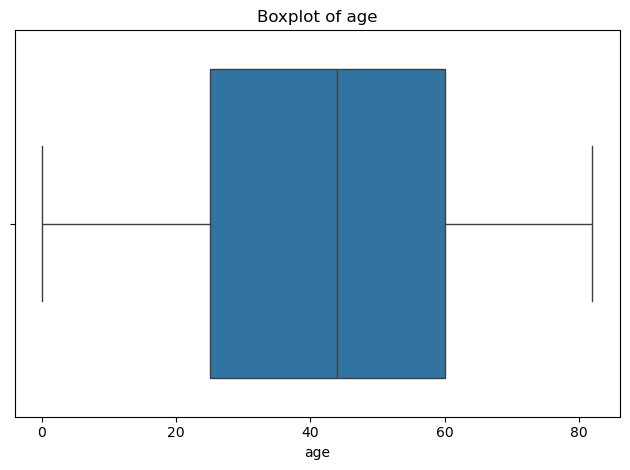

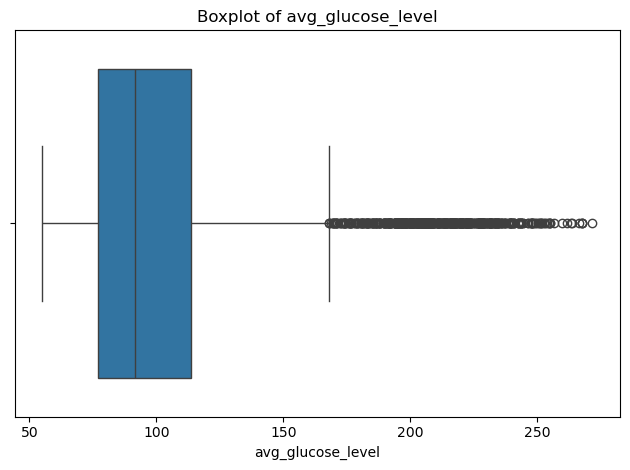

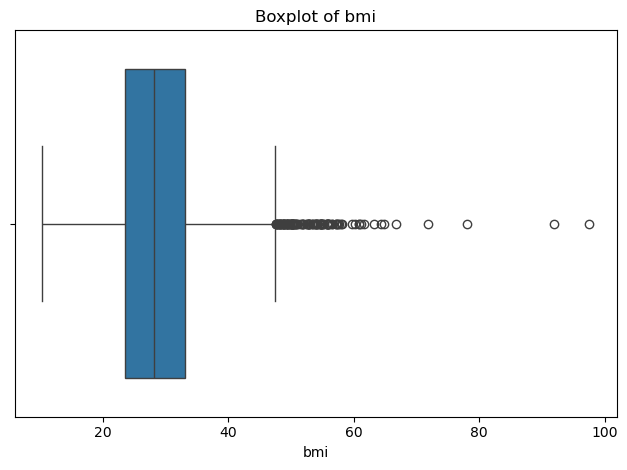

In [7]:
numerical_features = ['age', 'avg_glucose_level', 'bmi']

for col in numerical_features:
    sns.boxplot(x=df[col])
    plt.title(f'Boxplot of {col}')
    plt.savefig(f'boxplot_{col}.png')
    plt.tight_layout()
    plt.show()


### Interpret boxplots

Boxplots show outliers in bmi and glucose level, but this is reflect the real patient conditions. A stroke patient may actually have a BMI of 90 or glucose of 270, so removing these would hide critical clinical cases!

They are rare but valid, outliers in this dataset can help catch severe cases that models should learn.

# Ultilities

In [8]:
categorical_cols = ['gender', 'ever_married', 'work_type', 'Residence_type', 'smoking_status']
for col in categorical_cols:
    df[col] = df[col].astype('category')

# encoding
df_encoded = pd.get_dummies(df.drop(columns=['id']))

print(df_encoded.columns.tolist())

selected_features = [
    "age",
    "avg_glucose_level",
    "hypertension",
    "heart_disease",
    "smoking_status_Unknown",
    "ever_married_Yes",
    "work_type_Self-employed",
    "work_type_children",
    "work_type_Govt_job"
]

# Split features and labels
X = df_encoded[selected_features]
y = df_encoded['stroke']
# Split data into training (60%), validation (20%), and test (20%) sets
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y) 
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.25, random_state=42, stratify=y_train_val) 

# Scale the features
#scaler = StandardScaler()
X_train_scaled = StandardScaler().fit_transform(X_train)
X_val_scaled = StandardScaler().fit_transform(X_val)
X_test_scaled = StandardScaler().fit_transform(X_test)

# Apply SMOTE to handle class imbalance
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_scaled, y_train)


['age', 'hypertension', 'heart_disease', 'avg_glucose_level', 'bmi', 'stroke', 'gender_Female', 'gender_Male', 'ever_married_No', 'ever_married_Yes', 'work_type_Govt_job', 'work_type_Never_worked', 'work_type_Private', 'work_type_Self-employed', 'work_type_children', 'Residence_type_Rural', 'Residence_type_Urban', 'smoking_status_Unknown', 'smoking_status_formerly smoked', 'smoking_status_never smoked', 'smoking_status_smokes']


### Formal Feature Selection


In [9]:
class FormalFeatureSelection:
    def __init__(self, df, features, label):
        self.df = df
        self.features = features
        self.label = label
        
    def selectTopFeatures(self, top_n_anova=5, top_n_chi=5, top_n_rf=5, include_ref=5):
        self.featureSelectionSummary()
        top_features = self.feature_selection_summary
        anova_top = (
            top_features["Anova F"].sort_values(ascending=False).head(top_n_anova).index
        )
        chi2_top = (
            top_features["CHI2"].sort_values(ascending=False).head(top_n_chi).index
        )
        rf_top = (
            top_features["RF Importance"].sort_values(ascending=False).head(top_n_rf).index
        )
        rfe_top = (
            top_features["RFE Support"].sort_values(ascending=False).head(include_ref).index
        )
        self.top_features = set(anova_top).union(chi2_top).union(rf_top).union(rfe_top)
        display(top_features.loc[list(self.top_features)])

    def featureSelectionSummary(self):
        features = self.df.drop(columns=self.label)
        self.labels = self.df[self.label]
        self.features = pd.get_dummies(features)        
        
        #Anova F-Test
        skb_f = SelectKBest(score_func=f_classif, k="all").fit(self.features, self.labels)
        anova_scores = pd.Series(skb_f.scores_, index=self.features.columns).sort_values(ascending=False)

        #Normalize for Chi2
        scaler = MinMaxScaler()
        features_scaled = pd.DataFrame(
            scaler.fit_transform(self.features), columns=self.features.columns
        )
        
        #Chi2
        skb_chi2 = SelectKBest(score_func=chi2, k="all").fit(features_scaled, self.labels)
        chi2_scores = pd.Series(skb_chi2.scores_, index=self.features.columns).sort_values(ascending=False)

        #RandomForestImportances
        rf = RandomForestClassifier(random_state=0)
        rf.fit(self.features, self.labels)
        rf_scores = pd.Series(
            rf.feature_importances_, index=self.features.columns
        ).sort_values(ascending=False)

        #RFE - Logistic Regression
        lr = LogisticRegression(max_iter=4000)
        rfe = RFE(estimator=lr, n_features_to_select=10)
        rfe.fit(self.features, self.labels)
        rfe_support = pd.Series(rfe.support_, index=self.features.columns)

        
        self.feature_selection_summary = pd.DataFrame(
            {
                "Anova F": anova_scores,
                "CHI2": chi2_scores,
                "RF Importance": rf_scores,
                "RFE Support": rfe_support.astype(bool)
            }
        )

# EDA

## Univariate Distribution

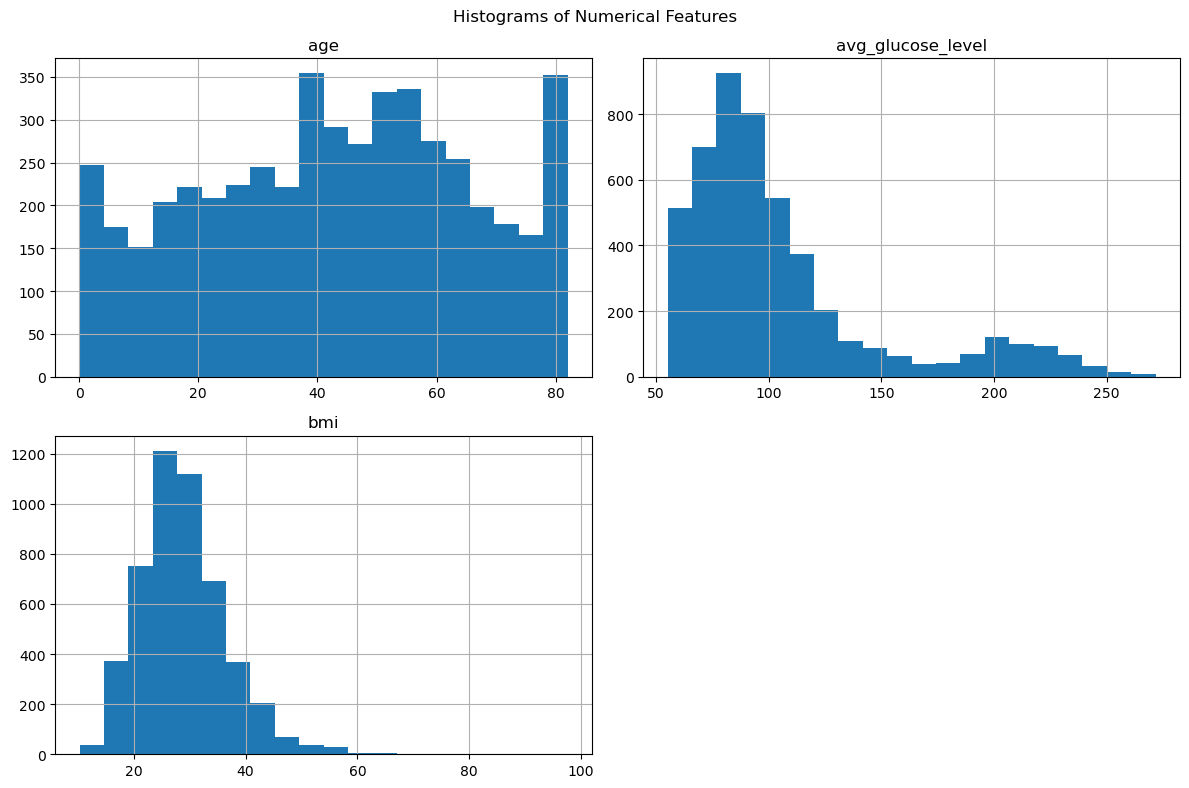

In [10]:
num_cols = ['age', 'avg_glucose_level', 'bmi']
df[num_cols].hist(bins=20, figsize=(12, 8))
plt.suptitle('Histograms of Numerical Features')
plt.savefig('histograms_numerical_features.png')
plt.tight_layout()
plt.show()

Numerical histograms: "age, avg_glucose_level, bmi" show right-skewed distributions, especially "avg_glucose_level".

Stroke distribution shows heavy imbalance between class 1 (stroke) and class 0 (no stroke) in the dataset. Class 1 is much less than Class 0. This could lead to poor model evaluation. To address this issue, we will use stratified sampling, SMOTE, and class weighting to improve the prediction of class 1 (stroke).  

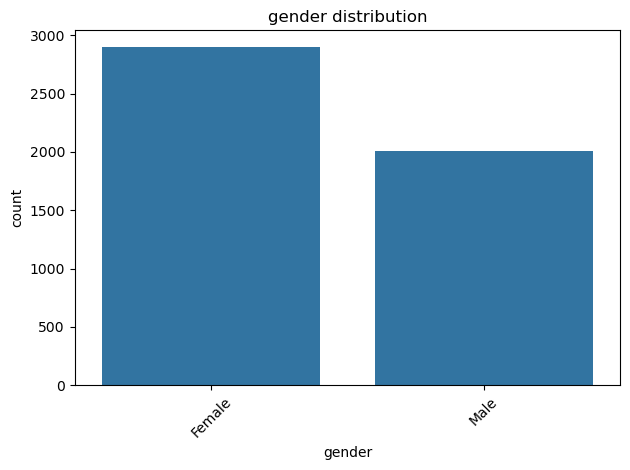

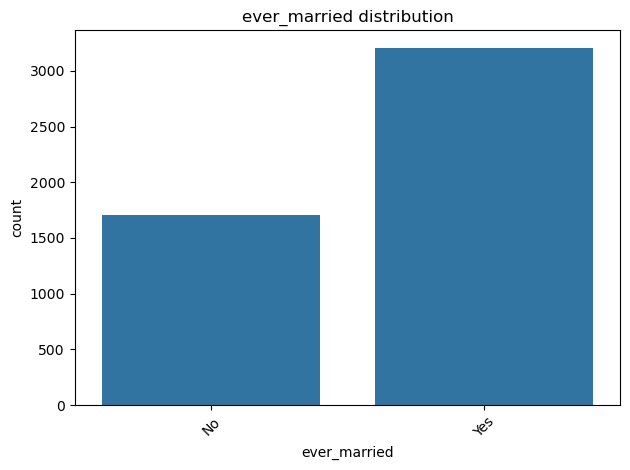

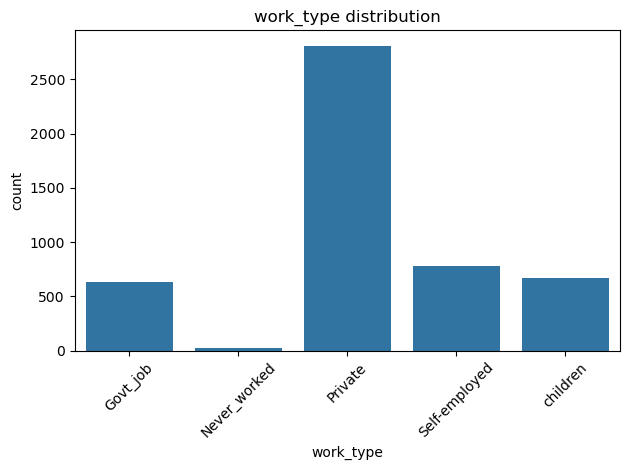

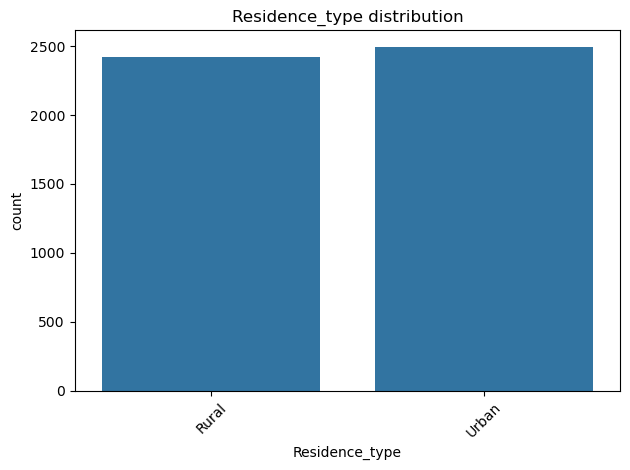

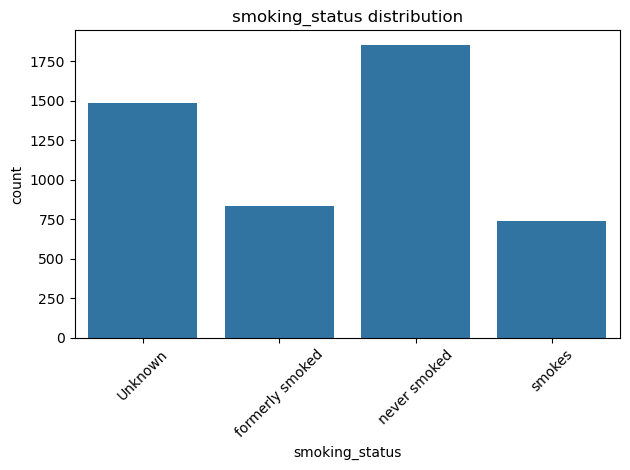

In [11]:
for col in categorical_cols:
    
    sns.countplot(x=col, data=df)
    plt.title(f'{col} distribution')
    plt.xticks(rotation=45)
    plt.savefig(f'countplot_{col}.png')
    plt.tight_layout()
    plt.show()

Categorical countplots like gender, smoking_status, work_type show: most patients are female and have never smoked. Majority work in the private sector.

# Bivariate Analysis

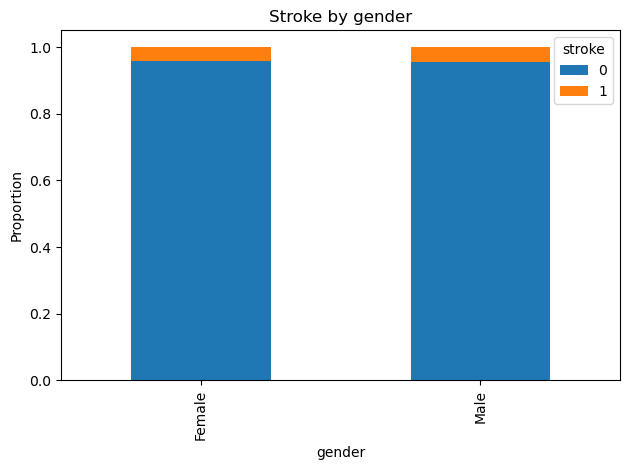

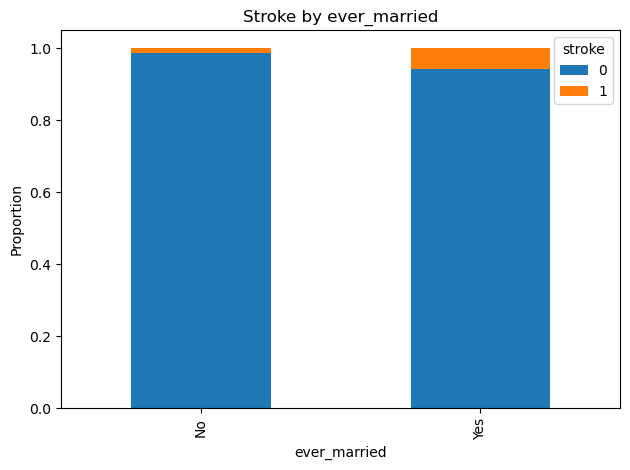

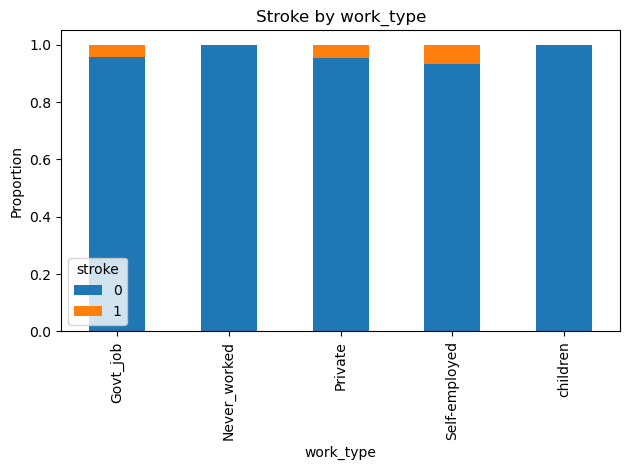

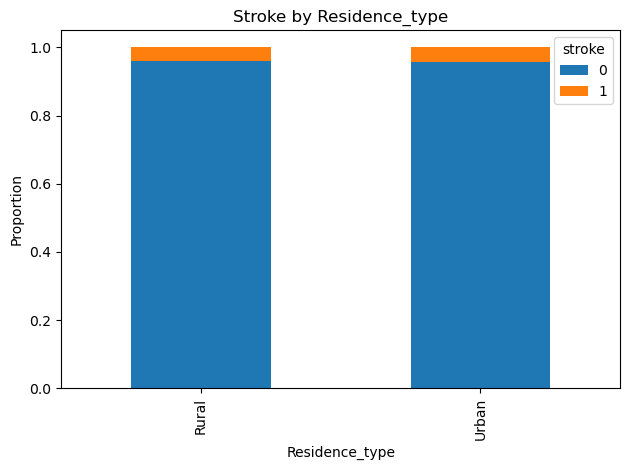

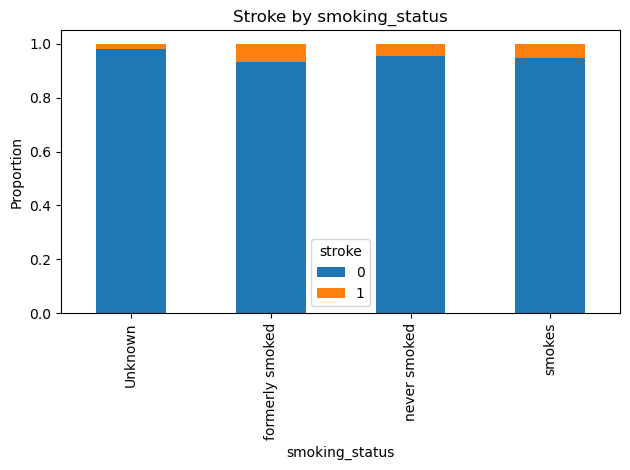

In [12]:
for col in categorical_cols:
    pd.crosstab(df[col], df['stroke'], normalize='index').plot(kind='bar', stacked=True)
    plt.title(f'Stroke by {col}')
    plt.ylabel('Proportion')
    plt.savefig(f'stroke_by_{col}.png')
    plt.tight_layout()
    plt.show()

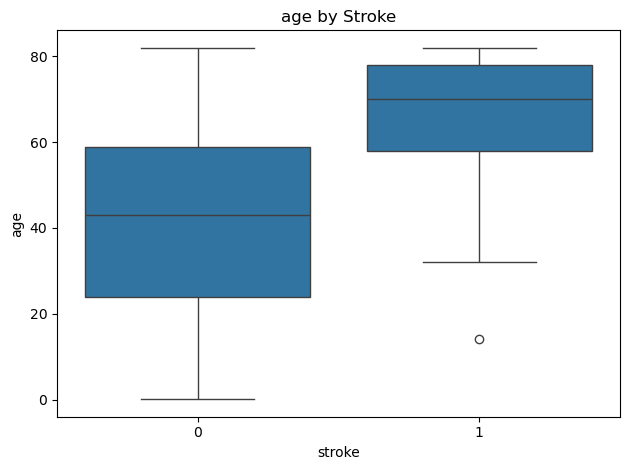

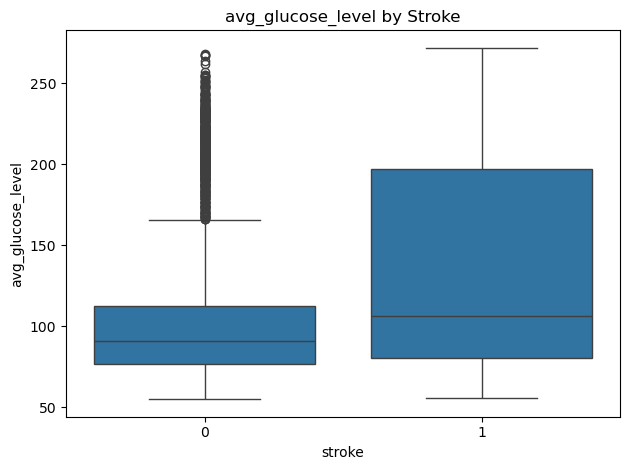

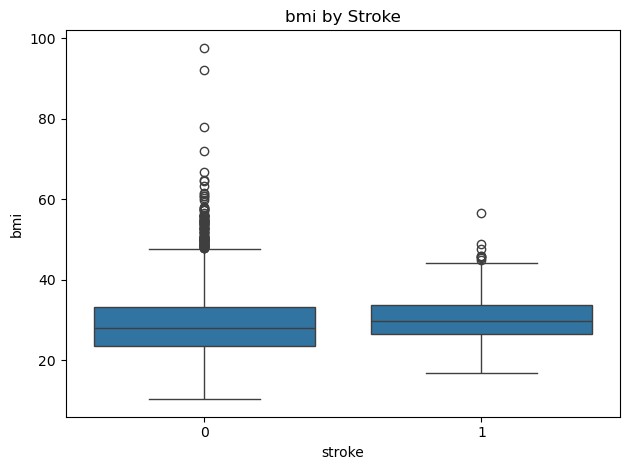

In [13]:
for col in num_cols:
    sns.boxplot(x='stroke', y=col, data=df)
    plt.title(f'{col} by Stroke')
    plt.savefig(f'boxplot_{col}_by_stroke.png') 
    plt.tight_layout()
    plt.show()

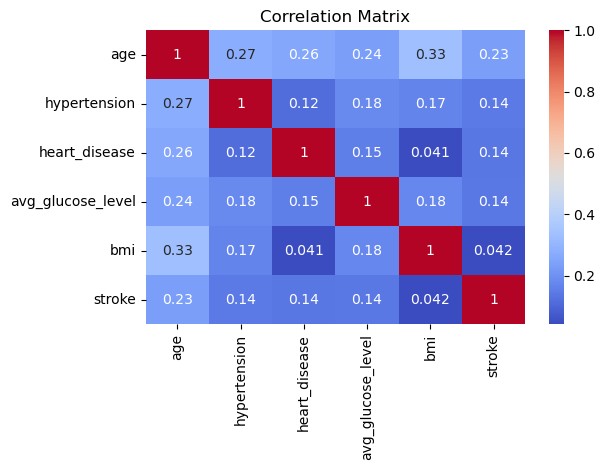

In [14]:
corr = df[['age', 'hypertension', 'heart_disease', 'avg_glucose_level', 'bmi', 'stroke']].corr()
sns.heatmap(corr, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.savefig('correlation_matrix.png')
plt.tight_layout()  
plt.show()

### Summary of Bivariate Analysis
| Feature        | Strength of Association with Stroke  | Notes                                                     |
| -------------- | -----------------------------------  | ------------------------------------------------------    |
| Age            | Strong                               | Older people much more likely to have stroke              |
| Glucose Level  | Moderate                             | High glucose is a risk factor                             |
| Smoking Status | Moderate                             | "Formerly smoked" and "smokes" show elevated stroke risk  |
| Hypertension   | Moderate                             | Medically important though correlation is weak            |
| Heart Disease  | Moderate                             | Similar to hypertension                                   |
| Ever Married   | Weak to Moderate                     | Marginal relationship with stroke
| Work Type      | Weak to Moderate                     | "Self-employed" and "Govt job" higher                     |
| BMI            | Weak                                 | Not strongly correlated alone                             |
| Gender         | Very Weak                            | No major difference                                       |
| Residence Type | None                                 | Urban and rural similar                                   |


In [15]:
fs = FormalFeatureSelection(df.drop(columns=['id']), df.columns.drop('stroke').tolist(), 'stroke')
fs.selectTopFeatures(top_n_anova=10)

,Anova F,CHI2,RF Importance,RFE Support
ever_married_No,54.745185,35.358312,0.008611,False
smoking_status_smokes,2.271562,1.930350,0.016776,True
age,279.878415,38.439000,0.229560,True
ever_married_Yes,54.745185,18.804795,0.009213,True
bmi,8.811194,0.334319,0.223467,False
work_type_Govt_job,0.061368,0.053512,0.014161,True
heart_disease,95.144282,88.749305,0.024598,True
smoking_status_Unknown,27.787710,19.290029,0.014621,True
smoking_status_formerly smoked,16.242036,13.436472,0.017791,False
work_type_Self-employed,15.069972,12.656637,0.018591,True


The following features were chosen based on a combination of statistical tests (ANOVA F-test, Chi²), model-based importance (Random Forest), and wrapper methods (RFE with Logistic Regression). These features consistently demonstrated strong association with the likelihood of stroke or were retained by multiple selection methods: \
            ["age","avg_glucose_level", \
            "hypertension","heart_disease", \
            "smoking_status_Unknown", \
            "ever_married_Yes", \
            "work_type_Selfemployed", \
            "work_type_children", \
            "work_type_Govt_job"]

# ANN model

In [16]:
# Train ANN model
ann_model = MLPClassifier(hidden_layer_sizes=(64, 32), activation='relu', max_iter=500, random_state=42)
ann_model.fit(X_train_resampled, y_train_resampled)

# Evaluate ANN on validation and test sets
val_preds_ann = ann_model.predict(X_val_scaled)
test_preds_ann = ann_model.predict(X_test_scaled)

print("ANN Validation Accuracy:", accuracy_score(y_val, val_preds_ann))
print("ANN Test Accuracy:", accuracy_score(y_test, test_preds_ann))
print("ANN Validation Classification Report:\n", classification_report(y_val, val_preds_ann))
print("ANN Test Classification Report:\n", classification_report(y_test, test_preds_ann))


ANN Validation Accuracy: 0.829938900203666
ANN Test Accuracy: 0.8543788187372708
ANN Validation Classification Report:
               precision    recall  f1-score   support

           0       0.97      0.84      0.90       940
           1       0.13      0.50      0.20        42

    accuracy                           0.83       982
   macro avg       0.55      0.67      0.55       982
weighted avg       0.94      0.83      0.87       982

ANN Test Classification Report:
               precision    recall  f1-score   support

           0       0.97      0.88      0.92       940
           1       0.12      0.38      0.18        42

    accuracy                           0.85       982
   macro avg       0.54      0.63      0.55       982
weighted avg       0.93      0.85      0.89       982



# Logistic Regression model

In [17]:
# Train Logistic Regression model
lr_model = LogisticRegression(max_iter=1000, random_state=42)
lr_model.fit(X_train_resampled, y_train_resampled)

# Evaluate Logistic Regression
val_preds_lr = lr_model.predict(X_val_scaled)
test_preds_lr = lr_model.predict(X_test_scaled)

print("Logistic Regression Validation Accuracy:", accuracy_score(y_val, val_preds_lr))
print("Logistic Regression Test Accuracy:", accuracy_score(y_test, test_preds_lr))
print("Logistic Regression Validation Classification Report:\n", classification_report(y_val, val_preds_lr, zero_division=0))  # set undefined precision to zero
print("Logistic Regression Test Classification Report:\n", classification_report(y_test, test_preds_lr, zero_division=0))  # set undefined precision to zero


Logistic Regression Validation Accuracy: 0.7729124236252546
Logistic Regression Test Accuracy: 0.7617107942973523
Logistic Regression Validation Classification Report:
               precision    recall  f1-score   support

           0       0.98      0.78      0.87       940
           1       0.12      0.71      0.21        42

    accuracy                           0.77       982
   macro avg       0.55      0.74      0.54       982
weighted avg       0.95      0.77      0.84       982

Logistic Regression Test Classification Report:
               precision    recall  f1-score   support

           0       0.98      0.77      0.86       940
           1       0.11      0.64      0.19        42

    accuracy                           0.76       982
   macro avg       0.54      0.70      0.52       982
weighted avg       0.94      0.76      0.83       982



In [18]:
coef_df = pd.DataFrame({
    'Feature': X.columns,
    'Coefficient': lr_model.coef_[0]
}).sort_values(by='Coefficient', ascending=False)

print("Logistic Regression Coefficients:\n", coef_df)

Logistic Regression Coefficients:
                    Feature  Coefficient
0                      age     2.064749
7       work_type_children     0.541791
2             hypertension     0.212887
1        avg_glucose_level     0.172760
3            heart_disease     0.066497
6  work_type_Self-employed    -0.144013
5         ever_married_Yes    -0.146776
8       work_type_Govt_job    -0.312871
4   smoking_status_Unknown    -0.458785


In this dataset, age has the strongest positive contributor to stroke risk.

# Gradient Boosting

### XGBoost

In [19]:
# Train XGBoost
xgb = XGBClassifier(
    use_label_encoder=False, # use_label_encoder=False to avoid deprecared automic encoding for target values
    eval_metric='logloss', # eval_metric='logloss' to optimize for binary classification
    random_state=42,
    scale_pos_weight = (y_train == 0).sum() / (y_train == 1).sum(), # handle class imbalance
    max_depth=4, # control tree complexity
    learning_rate=0.1, # smaller learning steps
    n_estimators=100, # number of boosting rounds
    subsample=0.8, # random sample of rows
    colsample_bytree=0.8 # random sample of features
)
xgb.fit(X_train_scaled, y_train)

# Evaluate XGBoost
val_preds_xgb = xgb.predict(X_val_scaled)
test_preds_xgb = xgb.predict(X_test_scaled)

y_probs = xgb.predict_proba(X_test_scaled)[:, 1]


print("XGBoost Validation Accuracy:", accuracy_score(y_val, val_preds_xgb))
print("XGBoost Test Accuracy:", accuracy_score(y_test, test_preds_xgb))
print("XGBoost Validation Classification Report:\n", classification_report(y_val, val_preds_xgb))
print("XGBoost Test Classification Report:\n", classification_report(y_test, test_preds_xgb)) 

XGBoost Validation Accuracy: 0.8309572301425662
XGBoost Test Accuracy: 0.8105906313645621
XGBoost Validation Classification Report:
               precision    recall  f1-score   support

           0       0.97      0.85      0.91       940
           1       0.10      0.36      0.15        42

    accuracy                           0.83       982
   macro avg       0.53      0.60      0.53       982
weighted avg       0.93      0.83      0.87       982

XGBoost Test Classification Report:
               precision    recall  f1-score   support

           0       0.98      0.82      0.89       940
           1       0.12      0.55      0.20        42

    accuracy                           0.81       982
   macro avg       0.55      0.68      0.55       982
weighted avg       0.94      0.81      0.86       982



C:\Users\Home\AppData\Roaming\Python\Python312\site-packages\xgboost\training.py:183: UserWarning: [19:10:23] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


### Light GBM

In [20]:

lgb_model = lgb.LGBMClassifier(random_state=42)
lgb_model.fit(X_train_scaled, y_train)

#Evaluate Light GBM
val_preds_lgbm = lgb_model.predict(X_val_scaled)
test_preds_lgbm = lgb_model.predict(X_test_scaled)

y_probs = lgb_model.predict_proba(X_test_scaled)[:, 1]

# lgb_auc = roc_auc_score(y_test, lgb_model.predict_proba(X_test)[:,1])

print("LGBM Validation Accuracy:", accuracy_score(y_val, val_preds_lgbm))
print("LGBM Test Accuracy:", accuracy_score(y_test, test_preds_lgbm))
print("LGBM Validation Classification Report:\n", classification_report(y_val, val_preds_lgbm))
print("LGBM Test Classification Report:\n", classification_report(y_test, test_preds_lgbm)) 

[LightGBM] [Info] Number of positive: 125, number of negative: 2819
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000405 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 374
[LightGBM] [Info] Number of data points in the train set: 2944, number of used features: 9
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.042459 -> initscore=-3.115824
[LightGBM] [Info] Start training from score -3.115824
LGBM Validation Accuracy: 0.9480651731160896
LGBM Test Accuracy: 0.9490835030549898
LGBM Validation Classification Report:
               precision    recall  f1-score   support

           0       0.96      0.99      0.97       940
           1       0.15      0.05      0.07        42

    accuracy                           0.95       982
   macro avg       0.56      0.52      0.52       982
weighted avg       0.92      0.95      0.93       98

### Cat Boost

In [21]:
df_cat = df.copy(deep=True).drop(columns=['id'])

#Fill missing values
# Separate numeric and categorical columns
numeric_cols = df_cat.select_dtypes(include=[np.number]).columns

# Impute numeric columns with median
df_cat[numeric_cols] = num_imputer.fit_transform(df_cat[numeric_cols])

X_cat = df_cat.drop('stroke', axis=1)
y_cat = df_cat['stroke']

X_train_cat, X_test_cat, y_train_cat, y_test_cat = train_test_split(
    X_cat, y_cat, stratify=y_cat, test_size=0.2, random_state=42
)

# 7. Get indices of categorical columns (for CatBoost)
cat_features_indices = [X_cat.columns.get_loc(col) for col in categorical_cols]

cat_model = CatBoostClassifier(verbose=0, random_state=42)
cat_model.fit(X_train_cat, y_train_cat, cat_features=cat_features_indices)

test_preds_cat = cat_model.predict(X_test_cat)

y_probs_cat = cat_model.predict_proba(X_test_cat)[:, 1]


print("Cat Test Accuracy:", accuracy_score(y_test, test_preds_cat))
print("Cat Test Classification Report:\n", classification_report(y_test, test_preds_cat)) 

NameError: name 'num_imputer' is not defined

# Support Vector Machine (SVM) Model

In [24]:
# Train SVM model
svm_model = SVC(kernel='linear', random_state=42)  # Using linear kernel for SVM
svm_model.fit(X_train_resampled, y_train_resampled)

# Evaluate SVM Regression
val_preds_svm = svm_model.predict(X_val_scaled)
test_preds_svm = svm_model.predict(X_test_scaled)

print("SVM Validation Accuracy:", accuracy_score(y_val, val_preds_svm))
print("SVM Test Accuracy:", accuracy_score(y_test, test_preds_svm))
print("SVM Validation Classification Report:\n", classification_report(y_val, val_preds_svm, zero_division=0)) # set undefined precision to zero    
print("SVM Test Classification Report:\n", classification_report(y_test, test_preds_svm, zero_division=0)) # set undefined precision to zero

SVM Validation Accuracy: 0.7678207739307535
SVM Test Accuracy: 0.7505091649694501
SVM Validation Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.77      0.86       940
           1       0.13      0.76      0.22        42

    accuracy                           0.77       982
   macro avg       0.56      0.76      0.54       982
weighted avg       0.95      0.77      0.84       982

SVM Test Classification Report:
               precision    recall  f1-score   support

           0       0.98      0.76      0.85       940
           1       0.11      0.64      0.18        42

    accuracy                           0.75       982
   macro avg       0.54      0.70      0.52       982
weighted avg       0.94      0.75      0.82       982



# Compute and plot model prediction error

In [30]:
# Create dictionary with model names and their predictions
models_predictions = {
    "ANN Classifier": test_preds_ann,
    "Logistic Regression": test_preds_lr,
    "XGBoost": test_preds_xgb,
    "SVM": test_preds_svm
}

# Caculate and plot models confusion matrix and heatmap

In [26]:
# Loop through each model and compute confusion matrix
for model_name, predictions in models_predictions.items():
    conf_matrix = confusion_matrix(y_test, predictions)
    print(f"{model_name} Confusion Matrix:\n{conf_matrix}\n")

ANN Classifier Confusion Matrix:
[[823 117]
 [ 26  16]]

Logistic Regression Confusion Matrix:
[[721 219]
 [ 15  27]]

XGBoost Confusion Matrix:
[[773 167]
 [ 19  23]]

SVM Confusion Matrix:
[[710 230]
 [ 15  27]]



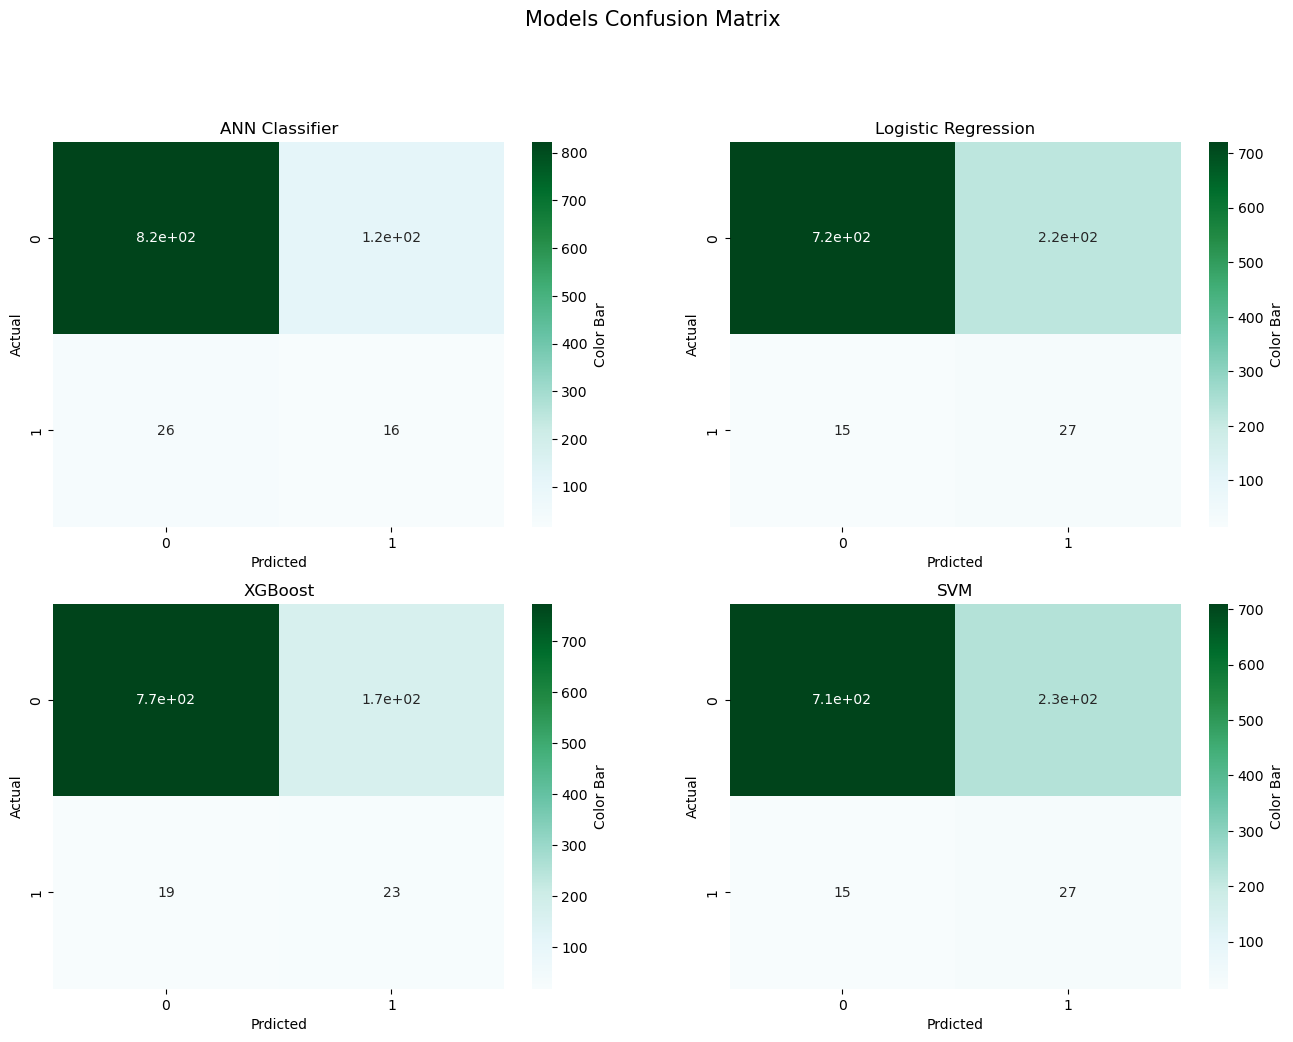

In [31]:
# Loop through each model and plot confusion matrix
plt_num = 1
plt.figure(figsize=(16,11)) # Set figure size
for model_name, predictions in models_predictions.items():
    conf_matrix = confusion_matrix(y_test, predictions)
    plt.subplot(2, 2, plt_num)
    sns.heatmap(conf_matrix, cmap="BuGn", annot=True, cbar_kws={"label":"Color Bar"}) 
    plt.suptitle('Models Confusion Matrix', fontsize=15, y=1)  
    plt.title(model_name), plt.xlabel('Prdicted'), plt.ylabel('Actual')
    plt.savefig('Confusion_Matrix.png')
    plt_num +=1

Use SHAP (SHapley Additive exPlanations) tool for interpretability machine learning model. SHAP is a framework that explains the output of machine learning models using Shapley values from game theory. It fairly distributes each feature's contribution to individual predictions

Reference: 
Lundberg, S. M. (n.d.). Basic SHAP interaction value example in XGBoost. SHAP Documentation. https://shap.readthedocs.io/en/latest/example_notebooks/tabular_examples/tree_based_models/Basic%20SHAP%20Interaction%20Value%20Example%20in%20XGBoost.html

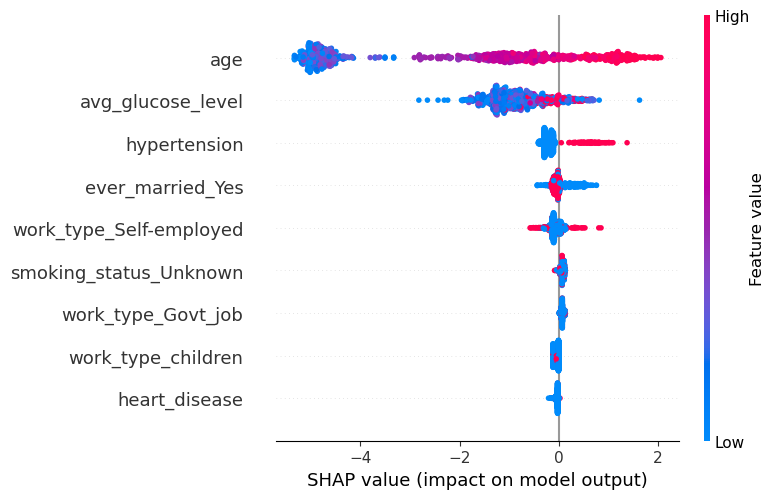

In [32]:

#model_name = [xgb]  # Use model objects, not strings
explainer = shap.TreeExplainer(xgb)
shap_values = explainer.shap_values(X_test_scaled)
shap.summary_plot(shap_values, X_test_scaled, feature_names=X.columns, show=False)
plt.savefig('SHAP_values.png')
plt.show()